## DeepExplain - Tensorflow example
### MNIST with a 2-layers MLP

In [1]:
import tensorflow as tf

In [2]:
tf.version

<module 'tensorflow._api.v1.version' from '/home/tiagobotari/anaconda3/envs/density-lime3.7/lib/python3.7/site-packages/tensorflow_core/_api/v1/version/__init__.py'>

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys
sys.path.append('..')

import tempfile, sys, os
sys.path.insert(0, os.path.abspath('..'))

import numpy as np 

from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf

from torch.utils.data import DataLoader
from torch.utils.data import IterableDataset
from m_lime.generators.vae_gen import VAEGen
from m_lime.explainers.explainer import Explainer
from m_lime.explainers.visualizations.visualization import ImagePlot

# Download and import MNIST data
tmp_dir = tempfile.gettempdir()
mnist = input_data.read_data_sets(tmp_dir, one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [4]:
# Parameters
learning_rate = 0.005
num_steps = 2000
batch_size = 128

# Network Parameters
n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)

# tf Graph input
X = tf.placeholder("float", [None, num_input])
Y = tf.placeholder("float", [None, num_classes])

# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([num_input, n_hidden_1], mean=0.0, stddev=0.05)),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2], mean=0.0, stddev=0.05)),
    'out': tf.Variable(tf.random_normal([n_hidden_2, num_classes], mean=0.0, stddev=0.05))
}
biases = {
    'b1': tf.Variable(tf.zeros([n_hidden_1])),
    'b2': tf.Variable(tf.zeros([n_hidden_2])),
    'out': tf.Variable(tf.zeros([num_classes]))
}

In [5]:
# Create and train model
def model(x, act=tf.nn.relu):  # < different activation functions lead to different explanations
    layer_1 = act(tf.add(tf.matmul(x, weights['h1']), biases['b1']))
    layer_2 = act(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']))
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

# Construct model
logits = model(X)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluate model (with test logits, for dropout to be disabled)
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Train
def input_transform (x): 
#     return x
    return (x - 0.5) *  2

sess = tf.Session()

# Run the initializer
sess.run(init)

for step in range(1, num_steps+1):
    batch_x, batch_y = mnist.train.next_batch(batch_size)
    batch_x = input_transform(batch_x)
    # Run optimization op (backprop)
    sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
    if step % 100 == 0 or step == 1:
        # Calculate batch loss and accuracy
        loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                             Y: batch_y})
        print("Step " + str(step) + ", Minibatch Loss= " + \
              "{:.4f}".format(loss) + ", Training Accuracy= " + \
              "{:.3f}".format(acc))

print("Done")

# Calculate accuracy for MNIST test images
test_x = input_transform(mnist.test.images)
test_y = mnist.test.labels

print("Test accuracy:", \
    sess.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Step 1, Minibatch Loss= 3.1693, Training Accuracy= 0.195
Step 100, Minibatch Loss= 0.2478, Training Accuracy= 0.914
Step 200, Minibatch Loss= 0.4199, Training Accuracy= 0.883
Step 300, Minibatch Loss= 0.2199, Training Accuracy= 0.953
Step 400, Minibatch Loss= 0.0975, Training Accuracy= 0.953
Step 500, Minibatch Loss= 0.2261, Training Accuracy= 0.953
Step 600, Minibatch Loss= 0.2378, Training Accuracy= 0.930
Step 700, Minibatch Loss= 0.1170, Training Accuracy= 0.961
Step 800, Minibatch Loss= 0.1290, Training Accuracy= 0.938
Step 900, Minibatch Loss= 0.1389, Training Accuracy= 0.953
Step 1000, Minibatch Loss= 0.0999, Training Accuracy= 0.984
Step 1100, Minibatch Loss= 0.1240, Training Accuracy= 0.961
Step 1200, Minibatch Loss= 0.1010, Training Accuracy= 0.961
Step 1300, Minibatch Loss= 0.0995, Traini

### Use DeepExplain to find attributions for each input pixel

In [6]:
test_idx = 0
xi = test_x[[test_idx]]
yi = test_y[test_idx] 

In [7]:
yi = test_y[test_idx] 
yi

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

In [8]:
 yi = test_y[test_idx] 

In [9]:
# Import DeepExplain
from deepexplain.tensorflow import DeepExplain
from utils import plot, plt
%matplotlib inline

# Define the input to be tested
test_idx = 0
# xi = test_x[[test_idx]]
# yi = test_y[test_idx] 
# x_explain = xi
x_explain = np.loadtxt('three_example.np').astype(np.float32).reshape(1, 28, 28)
xi = x_explain.reshape(1, 784)
yi = np.array([0.,0.,0.,0.,0.,0.,0.,0.,1.,0.])
# Create a DeepExplain context. 
# IMPORTANT: the network must be created within this context.
# In this example we have trained the network before, so we call `model(X)` to 
# recreate the network graph using the same weights that have been already trained.
with DeepExplain(session=sess) as de:
    logits = model(X)
    # We run `explain()` several time to compare different attribution methods
    attributions = {
        # Gradient-based
        'Saliency maps':        de.explain('saliency', logits * yi, X, xi),
        'Gradient * Input':     de.explain('grad*input', logits * yi, X, xi),
        'Integrated Gradients': de.explain('intgrad', logits * yi, X, xi),
        'Epsilon-LRP':          de.explain('elrp', logits * yi, X, xi),
        'DeepLIFT (Rescale)':   de.explain('deeplift', logits * yi, X, xi),
        #Perturbation-based
        '_Occlusion [1x1]':      de.explain('occlusion', logits * yi, X, xi),
        '_Occlusion [3x3]':      de.explain('occlusion', logits * yi, X, xi, window_shape=(3,))
    }
    print ('Done')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Done


In [10]:
import torch
def model_predict(x_):
    if isinstance(x_, torch.Tensor):
        x_ = x.detach().cpu().numpy()
    x_ = x_.reshape(-1, 784)
    batch_x = input_transform(x_)
    y_p = sess.run(logits, feed_dict={X: batch_x})
    return y_p

# MeLIME Explanation

In [11]:
# Using the same training data of the model to generate the generator VAEGen
class DatasetMNIST(IterableDataset):
    def __init__(self, data, batch_size):
        super().__init__()
        self.data = data
        self.batch_size = batch_size
        self.i = 0
        
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.i > self.data.train.num_examples:
            self.i = 0
            raise StopIteration
        else:
            self.i += self.batch_size
            return self.data.train.next_batch(self.batch_size)
        
    def __len__(self):
        return self.data.train.num_examples
train_dataset = DatasetMNIST(mnist, 1000)
train_loader = DataLoader(train_dataset)
generator = VAEGen(input_dim=784, verbose=False)
file_name = './model_vae_manifold_deep_explain.pth'
if os.path.isfile(file_name):
    generator = generator.load_manifold('./model_vae_manifold_deep_explain.pth')
else:
    generator.fit(train_loader, epochs=20)
    generator.save_manifold()

In [12]:
def get_explanation(x_explain, model_predict, class_to_explain, local_class, r):
    print("Explanation for: ", class_to_explain)
    print("Probability:", model_predict(x_explain)[0][class_to_explain])
    explain_linear = Explainer(
        model_predict=model_predict, generator=generator,
        local_model=local_class)
    explanation, contra = explain_linear.explain_instance(
        x_explain=x_explain,
        r=r,
        n_samples=1000,
        class_index=class_to_explain,
        tol_importance=0.01,
        tol_error=0.01,
        weight_kernel=None,
        local_mini_batch_max=200,
        scale_data=False
    )
    return explanation, contra
   
def explain(x_explain, model_predict, class_to_explain, local_class, r):
    explanation, contra = get_explanation(
        x_explain, model_predict, class_to_explain, local_class, r)
    fig, axis = ImagePlot.plot_importance_contrafactual(explanation.explain(), contra, class_to_explain)
    plt.savefig(
        f'MNIST_e_c_{class_to_explain}.png', dpi=300, interpolation='none')
    return explanation

In [13]:
local_class = 'SGD'
explain_linear = None
torch.cuda.empty_cache()

In [14]:
y_explain = model_predict(x_explain)
y_explain_index = np.argmax(y_explain)
print('Predicted:', y_explain_index, y_explain[0][y_explain_index])
top_three = np.argsort(y_explain)[0][::-1]
print('Top 3 predicted Class', top_three[:3])
y = f'Prediction: {np.argmax(y_explain):}'

Predicted: 3 11.234456
Top 3 predicted Class [3 8 5]


Explanation for:  3
Probability: 11.234456


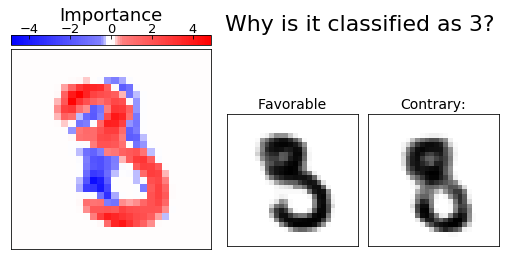

In [23]:
explanation = explain(
    x_explain, model_predict, top_three[0], local_class=local_class, r=0.1)

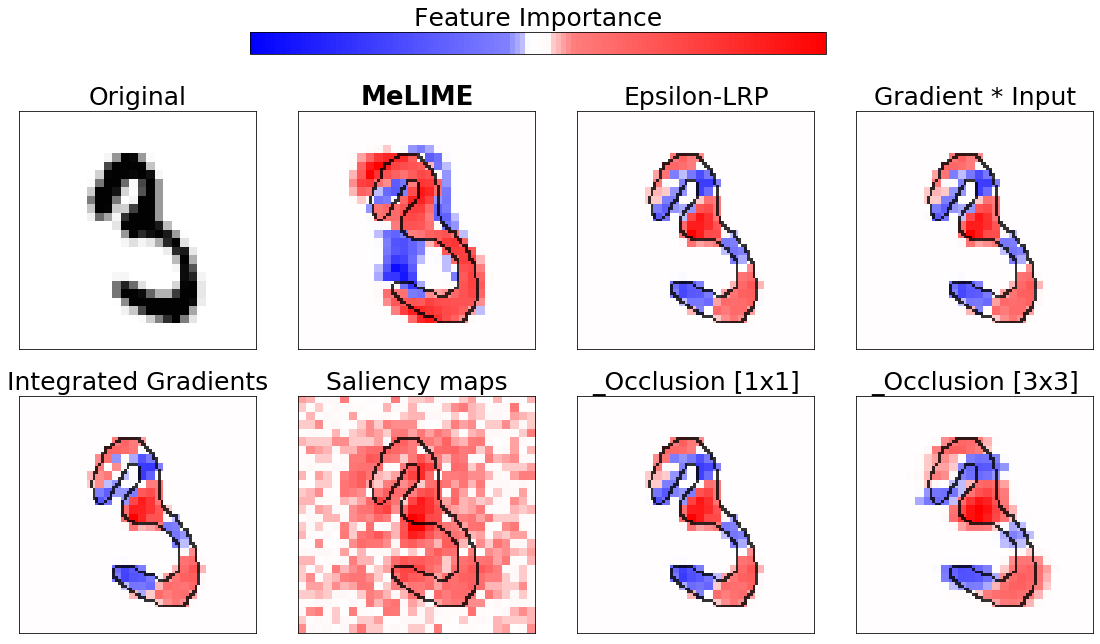

In [24]:
# Plot attributions
n_cols = len(attributions) + 2
n_cols = int(n_cols/2)
fig, axes = plt.subplots(nrows=2, ncols=n_cols, figsize=(20, 10))
axes = axes.flatten()
axes[0].imshow(xi.reshape(28, 28), interpolation='none', cmap='Greys')
ax2 = fig.add_axes([0.5-0.2, 0.93, 0.4, 0.03])
ax2.set_title('Feature Importance', fontsize=25)

axes[0].set_xticks([], [])
axes[0].set_yticks([], [])
axes[0].set_title('Original', fontsize=25)
i_ = 1
for i, method_name in enumerate(sorted(attributions.keys())):
    plot(
        attributions[method_name].reshape(28,28), xi=xi.reshape(28, 28), axis=axes[i+i_])
    axes[i+i_].set_title(method_name, fontsize=25)
    axes[i+i_].set_xticks([], [])
    axes[i+i_].set_yticks([], [])
axis, cp = plot(
    (explanation.importance.reshape(28,28)),
    xi = xi.reshape(28, 28), axis=axes[1])
axis.set_title('MeLIME', fontsize=26,  fontweight='bold')
plt.colorbar(cp, cax=ax2, orientation='horizontal')
# ax2.set_xticks([], [])
# ax2.set_yticks([], [])
ax2.axis('off')
plt.subplots_adjust(top=0.85, wspace=0.0, hspace=0.2)
plt.savefig('importance_number_depp_explain.png', dpi=300)